In [9]:
import pandas as pd
import os
import numpy as np
import shutil
from glob import glob
from tqdm import tqdm
import yaml
import random

import cv2
import torch
from IPython.display import Image, clear_output
# from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(0)
np.random.seed(0)

In [ ]:
# get yolov5 model
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# !pip install -U pycocotools
# !pip install -qr yolov5/requirements.txt  # install dependencies
# !cp yolov5/requirements.txt ./

In [50]:
ORIGINAL_DATASET_PATH = './self_driving_dataset/'
ORIGINAL_IMAGES_PATH = './self_driving_dataset/images/'

TRAIN_LABELS_PATH = './datasets/self_driving/labels/train'
VAL_LABELS_PATH = './datasets/self_driving/labels/val'
TRAIN_IMAGES_PATH = './datasets/self_driving/images/train'
VAL_IMAGES_PATH = './datasets/self_driving/images/val'

os.makedirs(TRAIN_LABELS_PATH, exist_ok = True)
os.makedirs(VAL_LABELS_PATH, exist_ok = True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok = True)
os.makedirs(VAL_IMAGES_PATH, exist_ok = True)

In [39]:
filenames = glob(ORIGINAL_IMAGES_PATH + '*')
dataset_size = len(filenames)
print(dataset_size)

22241


In [41]:
img_h, img_w, num_channels = (300, 480, 3)

def preprocess(csv_path):

    df = pd.read_csv(csv_path)
    df.rename(columns={'frame':'image_id'}, inplace=True)
    # change to 0 index
    df['class_id'] = df['class_id'].apply(lambda x: x-1)
    df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
    #df['classes'] = 0
    df['x'] = (df['xmin'] + df['xmax'])/2
    df['y'] = (df['ymin'] + df['ymax'])/2
    df['w'] = df['xmax'] - df['xmin']
    df['h'] = df['ymax'] - df['ymin']
    # normalize
    df['x'] = df['x']/img_w
    df['y'] = df['y']/img_h
    df['w'] = df['w']/img_w
    df['h'] = df['h']/img_h
    print(df.head())
    return df

train_csv_path = ORIGINAL_DATASET_PATH + 'labels_train.csv'
val_csv_path = ORIGINAL_DATASET_PATH + 'labels_val.csv'
df_train = preprocess(train_csv_path)
df_val = preprocess(val_csv_path)



              image_id  xmin  xmax  ymin  ymax  class_id         x         y  \
0  1478019952686311006   237   251   143   155         0  0.508333  0.496667   
1  1478019952686311006   437   454   120   186         2  0.928125  0.510000   
2  1478019953180167674   218   231   146   158         0  0.467708  0.506667   
3  1478019953689774621   171   182   141   154         1  0.367708  0.491667   
4  1478019953689774621   179   191   144   155         0  0.385417  0.498333   

          w         h  
0  0.029167  0.040000  
1  0.035417  0.220000  
2  0.027083  0.040000  
3  0.022917  0.043333  
4  0.025000  0.036667  
              image_id  xmin  xmax  ymin  ymax  class_id         x         y  \
0  1478899046136829030   201   206   129   135         4  0.423958  0.440000   
1  1478899046136829030   203   210   150   158         0  0.430208  0.513333   
2  1478899046136829030   215   219   130   135         4  0.452083  0.441667   
3  1478899046136829030   222   234   145   162         

In [46]:
print(len(df_train))
print(len(df_val))
assert dataset_size == (len(set(df_train.image_id)) + len(set(df_val.image_id)))

132406
32699


Image ID: 1478020417697698243


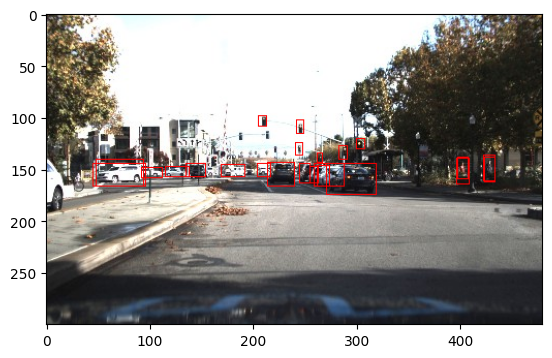

In [47]:
# show a sample
index = list(set(df_train.image_id))
sample_image = random.choice(index)
#sample_image = list(df_train.image_id)[3]
print("Image ID: %s"%(sample_image))
#img = cv2.imread(f'./self_driving_dataset/images/{sample_image}.jpg')
#Image(filename=f'./self_driving_dataset/images/{sample_image}.jpg', width=img_w)

def show_bbox(df, image):

    df_image = df.loc[df['image_id'] == image]
    #print(df_image)

    image_to_show = cv2.imread(f'./self_driving_dataset/images/{image}.jpg')

    for i in df_image.index:
        x = float(df_image.loc[i, 'x'])
        y = float(df_image.loc[i, 'y'])
        w = float(df_image.loc[i, 'w'])
        h = float(df_image.loc[i, 'h'])
        # print(x,y,w,h)

        x1 = int( (x - w/2) * img_w )
        y1 = int( (y - h/2) * img_h )
        x2 = int( (x + w/2) * img_w )
        y2 = int( (y + h/2) * img_h )

        cv2.rectangle(image_to_show, (x1, y1), (x2, y2), (0,0,255), 1)
    
    img_rgb = cv2.cvtColor(image_to_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

show_bbox(df_train, sample_image)

In [49]:
def create_yolo_dataset(df, labels_path, images_path):

    for column, row in tqdm(df.iterrows(), total=len(df)):
        attributes = row[['class_id','x','y','w','h']].values
        attributes = np.array(attributes)

        filename = os.path.join(labels_path, f"{row['image_id']}.txt")
        with open(filename, 'ab') as f:
            np.savetxt(f, [attributes], fmt = ['%d', '%f', '%f', '%f', '%f'])
        
        shutil.copy(os.path.join(ORIGINAL_IMAGES_PATH, f"{row['image_id']}.jpg"), images_path)


In [52]:
create_yolo_dataset(df_train, TRAIN_LABELS_PATH, TRAIN_IMAGES_PATH)
#create_yolo_dataset(df_val, VAL_LABELS_PATH, VAL_IMAGES_PATH)

100%|██████████| 132406/132406 [00:45<00:00, 2890.66it/s]


In [53]:
classes = [ 'car',
            'truck',
            'pedestrian',
            'bicyclist',
            'light']

data = dict(
    path  =  '../datasets/self_driving',
    train =  'images/train',
    val   =  'images/val',
    nc    = 5,
    names = classes
    )

with open('self_driving_autogen.yaml', 'w') as outfile:
    yaml.dump(data, outfile)
    
f = open('./self_driving_autogen.yaml', 'r')
print('\nyaml:')
print(f.read())
f.close()


yaml:
names:
- car
- truck
- pedestrian
- bicyclist
- light
nc: 5
path: ../datasets/self_driving
train: images/train
val: images/val



In [56]:
clear_output()
#!python ./yolov5/train.py --data self_driving.yaml --weights yolov5s6.pt --img 480 --epochs 20 --batch 16 --freeze 10

In [ ]:
# def split_dataset(animal, image_names, train_size, val_size):
#     for i, image_name in enumerate(image_names):
#         # Label filename
#         label_name = image_name.replace('.jpg', '.txt')
        
#         # Split into train, val, or test
#         if i < train_size:
#             split = 'train'
#         elif i < train_size + val_size:
#             split = 'val'
#         else:
#             split = 'test'
        
#         # Source paths
#         source_image_path = f'download/{animal}/images/{image_name}'
#         source_label_path = f'download/{animal}/darknet/{label_name}'

#         # Destination paths
#         target_image_folder = f'data/images/{split}'
#         target_label_folder = f'data/labels/{split}'

#         # Copy files
#         shutil.copy(source_image_path, target_image_folder)
#         shutil.copy(source_label_path, target_label_folder)

# # Cat data
# split_dataset('cat', cat_images, train_size=400, val_size=50)

# # Dog data (reduce the number by 1 for each set due to three duplicates)
# split_dataset('dog', dog_images, train_size=399, val_size=49) 